In [1]:
plaidML = True
if plaidML == False:
    import pandas as pd
    import numpy as np
    import os
    import random
    import matplotlib.pyplot as plt
    import cv2
    import pickle
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.metrics import categorical_crossentropy
else:
    import os
    print("plaidMl env setting....")
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    import pandas as pd
    import numpy as np
    import random
    import matplotlib.pyplot as plt
    import cv2
    import pickle
    import keras
    from keras import layers
    from keras.optimizers import Adam
    from keras.metrics import categorical_crossentropy
    from keras.callbacks import EarlyStopping    
    from keras.callbacks import ModelCheckpoint
    from keras.models import load_model    
    from keras.applications.resnet50 import ResNet50
    from keras.applications.vgg16 import VGG16

   

ENV = "Local_PC"
DATA_AUGMENT = False  # default set to false after data is already augmented.
DATA_PREPARE = False 
MODEL_TRAINING = False
MODEL_TESTING = False
TRANSFER_LEARNING = False
TRANSFER_LEARNING_AUG = True

D:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\parentpoller.py:110: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


plaidMl env setting....


Using plaidml.keras.backend backend.


In [2]:
if ENV == "Local_PC":
    train_folder = "D:/University Course/7088/Dataset/Beans Leaf disease/train"
    test_folder = "D:/University Course/7088/Dataset/Beans Leaf disease/test"
    validation_folder = "D:/University Course/7088/Dataset/Beans Leaf disease/validation"

    folder_path_healthy = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/healthy'
    folder_path_bean_rust = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/bean_rust'
    folder_path_angular_leaf_spot = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/angular_leaf_spot'

    folder_path_healthy_aug = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/healthy_aug'
    folder_path_bean_rust_aug = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/bean_rust_aug'
    folder_path_angular_leaf_spot_aug = 'D:/University Course/7088/Dataset/Beans Leaf disease/train/angular_leaf_spot_aug'
      
else:
    train_folder = "/content/drive/MyDrive/Colab Notebooks/data/"

In [3]:
CATEGORIES = ["healthy","bean_rust","angular_leaf_spot"]
CATEGORIES_AUG = ["healthy_aug","bean_rust_aug","angular_leaf_spot_aug"]


### Utility function to count files in each subfolder

In [4]:
#count all the files present in each subfolder
def count_files (root_folder):
    total_count =0
    for name in os.listdir(root_folder):
        count_file=0
        for files in os.listdir(os.path.join(root_folder,name)):
            count_file = count_file+1
        print("Folder :", name, "File Count :", count_file)
        total_count = total_count+count_file
        
    print("\n Total files in {} : {}".format(train_folder,total_count))
    


### Function to augment the training images   
Perform augmentation for every image in the folder   
1. Add random noise to each image and save it back in folder
2. Horizontol flip each image and save it back in folder
3. Vertical flip each image and save it back in folder
4. Vertical/horizontal flip the image ( both flips)
5. Blur the image to smooth the image 
6. Randomly rotate the image between 5-20 degree

In [5]:
from skimage.util import random_noise, img_as_ubyte
from skimage.transform import rotate
from skimage import io

# src_folder - path which contains images which needs to be augmented
# dest_folder - path where new images should be stored after data augmentation

def augment_data(src_folder, dest_folder):
    
    prefix = "aug_"
    file_number = 1
    #fig,axs = plt.subplots(3,2,figsize=(12,12))
    for file in os.listdir(src_folder):
        try:
            img_bgr = cv2.imread(os.path.join(src_folder,file)) # read the file : by default its rgb format
            img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB) # convert into rgb format before augmentation
            # Add random noise
            img_random_noise = random_noise(img_rgb,seed=13)
            
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            io.imsave(dest_path,img_as_ubyte(img_random_noise)) # use skimage to save image because augmentation is done using skimage
            
            # Horizontal flip the image
            img_h_flip = cv2.flip(img_bgr,1)  # second parameter is 1 for flipping around y axis i.e. horizontal flipping
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            cv2.imwrite(dest_path,img_h_flip)
            
            # vertical flip the image
            img_v_flip = cv2.flip(img_bgr,0)  # second parameter is 0 for flipping around x axis i.e. vertical flipping
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            cv2.imwrite(dest_path,img_v_flip)
            
            # vertical/horizontal flip the image
            img_both_flip = cv2.flip(img_bgr,-1)  # second parameter is -1 for flipping around both x and y axis i.e. vertical & horizontal flipping
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            cv2.imwrite(dest_path,img_both_flip)
            
            # blur the image to smooth the image 
            img_blur = cv2.GaussianBlur(img_bgr,(5,5),0)  # Gaussian blur to smooth the image
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            cv2.imwrite(dest_path,img_blur)
            
            #randomly rotate the image between 5-20 degree
            img_random_rotate = rotate(img_rgb,random.randint(5,20),mode='constant')
            dest_path = os.path.join(dest_folder,(prefix+str(file_number)+"_"+file))
            file_number = file_number+1 # increment the file number
            io.imsave(dest_path,img_as_ubyte(img_random_rotate)) # use skimage to save image because augmentation is done using skimage
            
            # Temporary code for debugging - plot to check if images are augmented correctly
#             axs[0][0].imshow(img_random_rotate)
#             axs[0][0].set_title("Randomly Rotate Image")
#             axs[0][1].imshow(img_random_noise)
#             axs[0][1].set_title("With added Random Noise")                                   
#             axs[1][0].imshow(img_h_flip)
#             axs[1][0].set_title("Horizontal Flip Image")
#             axs[1][1].imshow(img_v_flip)
#             axs[1][1].set_title("Vertical Flip Image")
#             axs[2][0].imshow(img_both_flip)
#             axs[2][0].set_title("Both Flip Image")
#             axs[2][1].imshow(img_blur)
#             axs[2][1].set_title("Gaussian Blur Image")
#             break
            print(".", end='')
        except:
            print("Augment Data: Error in file reading...exiting")
            break
            
    

### Function to preapre dataset for neural network training   
1. Read all the files from the folder   
2. Keep the files in RGB format   
3. Resize all the images into common size   
4. Create label for each file as per the category   
5. Shuffle the data to mix all the classes   
6. Return prepared X(image array) and y ( labels) for all the images

In [6]:
# folder - Name of folder which contain all the images : subfolder names are as per different classes
# categories -  list of all the classes
# img_size - Standard size which is used for resizing all the images : by default set to 256
# col ::'gray' or 'rgb'

def prepare_dataset(folder, categories, img_size=256,col='rgb'):
    
    dataset = []
    IMG_SIZE=img_size
    CATEGORIES = categories
    
    if col=='rgb':
        channel = 3
    elif col=='gray': # for gray
        channel = 1
    else:
        print("\n Incorrect Channel information..Only 'gray' or 'rgb' supported")
        return -1
    
    for labels in CATEGORIES:
        path = os.path.join(folder, labels) # join the path with category folder name
        class_num = CATEGORIES.index(labels)

        for file in os.listdir(path):        # read all the files from inside the class folder
            try:
                
                img_array =cv2.imread(os.path.join(path,file)) # read image into an array
                
                if col=='rgb':
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                elif col =='gray':
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                    
                new_array =cv2.resize(img_array, (IMG_SIZE,IMG_SIZE)) # resize all the images to common size
                dataset.append([new_array,class_num])        
            except:
                print("Folder Path: ",os.path.join(path,file))
                print("prepare_dataset: Error in file reading...exiting")
                break
        print(".", end='')
        
    # shuffle the dataset 
    random.shuffle(dataset)
    print("\nLength of dataset : ",len(dataset))

    #create X and y for
    X=[]
    y=[]
    for feature,label in dataset:
        X.append(feature)
        y.append(label)

    #reshape the X array to make compatible for neural network training
    X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,channel) # 1 is for gray scale image, 3 is for rgb

    print("Shape of X - dataset: ", X.shape)
    print("Length of y - dataset: ", len(y))
    
    return X,y

# Data Preprocessing

### Check total available original files for training data before Augmentation

In [7]:
if DATA_AUGMENT:
    # Check total files present in training folder    
    count_files(train_folder)

### Augment Training data - All the classes data
Create new 6 images for each image in each class

In [8]:
if DATA_AUGMENT:
    #Augment Training Data 
    # 1. Healthy Data
    augment_data(folder_path_healthy,folder_path_healthy_aug)

In [9]:
if DATA_AUGMENT:
    # 2. bean_rust
    augment_data(folder_path_bean_rust,folder_path_bean_rust_aug)

In [10]:
if DATA_AUGMENT:
    # 3. Angular Leaf Spot
    augment_data(folder_path_angular_leaf_spot,folder_path_angular_leaf_spot_aug)

### Check total available original files for training data after Augmentation

In [11]:
if DATA_AUGMENT:
    # Check total files present in training folder after data augmentation  
    count_files(train_folder)

## Data preparing

## A. Prepare dataset with orginal images for neural network training

In [12]:
if DATA_PREPARE :
    #prepare training dataset
    X_train,y_train = prepare_dataset(train_folder,CATEGORIES)

In [13]:
if DATA_PREPARE:
    #prepare testing dataset
    X_test,y_test = prepare_dataset(test_folder,CATEGORIES)

In [14]:
if DATA_PREPARE:
    #prepare validation dataset
    X_validate,y_validate = prepare_dataset(validation_folder,CATEGORIES)

## B. Prepare dateset with Augmented image for neural network training
We will only use augmented images

In [15]:
if DATA_PREPARE:
    #prepare training dataset
    X_train_aug,y_train_aug = prepare_dataset(train_folder,CATEGORIES_AUG)
    

In [16]:
if DATA_PREPARE:  ## FOR GRAY IMAGES
    #prepare gray image data array for augmented images

    X_train_aug_gray ,y_train_aug_gray = prepare_dataset(train_folder,CATEGORIES_AUG,col='gray')
    
    X_validate_gray,y_validate_gray = prepare_dataset(validation_folder,CATEGORIES,col='gray')
    
    #augmented  gray image data
    path = os.path.join(train_folder,"DataArray")

    pickle.dump(X_train_aug_gray, open(os.path.join(path,"X_train_aug_gray.npy"),'wb'))
    pickle.dump(y_train_aug_gray, open(os.path.join(path,"y_train_aug_gray.npy"),'wb'))

    pickle.dump(X_validate_gray, open(os.path.join(path,"X_validate_gray.npy"),'wb'))
    pickle.dump(y_validate_gray, open(os.path.join(path,"y_validate_gray.npy"),'wb'))
    

### Pickle X and y matrices for future usages 
1. Pickle X_train, y_train for Original images
2. Pickle X_train_aug, y_train_aug for augmented images

In [17]:
if DATA_PREPARE:
    path = os.path.join(train_folder,"DataArray")

    #original image data
    pickle.dump(X_train, open(os.path.join(path,"X_train.npy"),'wb'))
    pickle.dump(y_train, open(os.path.join(path,"y_train.npy"),'wb'))
    
    #augmented image data
    pickle.dump(X_train_aug, open(os.path.join(path,"X_train_aug.npy"),'wb'))
    pickle.dump(y_train_aug, open(os.path.join(path,"y_train_aug.npy"),'wb'))

    #original image data
    pickle.dump(X_test, open(os.path.join(path,"X_test.npy"),'wb'))
    pickle.dump(y_test, open(os.path.join(path,"y_test.npy"),'wb'))

    #original image data
    pickle.dump(X_validate, open(os.path.join(path,"X_validate.npy"),'wb'))
    pickle.dump(y_validate, open(os.path.join(path,"y_validate.npy"),'wb'))
    
    #delete these big arrays and free memory
    %xdel X_train
    %xdel X_train_aug
    %xdel X_train_aug_gray
    %xdel X_test
    %xdel X_validate
    %xdel y_train
    %xdel y_train_aug
    %xdel y_train_aug_gray
    %xdel y_test
    %xdel y_validate


In [18]:
if DATA_PREPARE:
    # Read back to check if files were saved correctly
    temp_X_train_aug = pickle.load( open( os.path.join(path,"X_train_aug.npy"), "rb" ) )
    print("X Shape: ", temp_X_train_aug.shape)

    temp_y_train_aug = pickle.load( open( os.path.join(path,"y_train_aug.npy"), "rb" ) )
    print("Y length: ", len(temp_y_train_aug))


In [19]:
if DATA_PREPARE:
    # plot some random images from each class of augmented dataset
    image_class = { 0: "healthy", 1: "bean_rust", 2:"angular_leaf_spot"}

    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        index=random.randint(0,5170)
        plt.imshow(temp_X_train_aug[index])
        title= "Label: "+ image_class[temp_y_train_aug[index]]
        plt.title(title)
    


### 1.1 Load the images into CNN model and train the model

In [20]:
# Function to load dataset for network training
#x - X.npy : X input 
#y - y.npy : y Input
#train_folder : folder which contains array image file
#Path is pre-set to train folder : All the npy pickled file should be stored there
#col :: 'rgb' or 'gray'

def load_training_dataset(x, y, train_folder,col="rgb"):
    
    if col == 'rgb':
        channel =3
    else: # if col == "gray"
        channel =1
        
    print("\n Loading : ", x ," ", y)
    path = os.path.join(train_folder,"DataArray")
    temp_X_train = pickle.load( open( os.path.join(path,x), "rb" ) )
    print("X Shape: ", temp_X_train.shape)

    temp_y_train = pickle.load( open( os.path.join(path,y), "rb" ) )
    print("Y length: ", len(temp_y_train))  

        
    #reshape the dataset

    #building the input vector from 256x256 pixels
    temp_X_train = temp_X_train.reshape(temp_X_train.shape[0],256,256,channel)
    temp_X_train = temp_X_train.astype('float32')

    #normalize the data
    temp_X_train = temp_X_train/255

    #convert into an array
    temp_y_train = keras.utils.to_categorical(temp_y_train, 3)  # 3 is no. of output label classes

    return temp_X_train, temp_y_train



# Model helper functions  
1. Create the model :: create_model(...)
2. Compile and fit the training data ::  compile_fit_model(...)
3. Check trained model performance :: model_performance(...)

In [21]:
#Create the model skeleton
def create_model(model_name,col='rgb'):
    
    if col == 'rgb':
        channel =3
    else:
        channel =1
        
    # building a linear stack of layers with the sequential model
    keras.backend.clear_session()
    model = keras.Sequential(name=model_name)
    # convolutional layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(256, 256, channel)))

    # convolutional layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.25))

    # flatten output of conv
    model.add(layers.Flatten())

    # hidden layer
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(250, activation='relu'))
    model.add(layers.Dropout(0.3))
    # output layer
    model.add(layers.Dense(3, activation='softmax'))

    model.summary()
    
    return model

In [22]:
# Compile and fit the trainning data, saves the best performing model on disk
#Function Argument::
# model - model instanance
# no_of_epoch - number of epochs to run
# model_name - Name of model - "string"
# train_folder -  Folder address which contain "DataArray" for saving model

# RETURNS::
# history - Contains evaluation metrics of model

def compile_fit_model(model,model_name, X_train, y_train,X_validate,y_validate, no_of_epoch=15,train_folder="D:/University Course/7088/Dataset/Beans Leaf disease/train"):
       
    model_name= model_name+"_Best_model.h5"  
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], \
                  optimizer='adam')
    
    #set call for early stopping for monitoring model performance
    es_callback = EarlyStopping(monitor='val_loss',mode='min',verbose=1,\
                                patience=3)
    
    #checkpoint for models - for saving the best model observed during the training
    path = os.path.join(train_folder,"DataArray")
    best_model=ModelCheckpoint(os.path.join(path,model_name), \
                               monitor="val_loss",mode='min', \
                               save_best_only=True, verbose=1)
    
    # training the model for n epochs
    epochs_num = no_of_epoch
    history= model.fit(X_train, y_train, batch_size=25, epochs=epochs_num, \
                       validation_data=(X_validate,y_validate),verbose=1, \
                       callbacks=[es_callback,best_model] )    
    
    return history
        

In [23]:
# Model performance :: plot loss and accuracy for training and validation dataset
#Function Arugument
# history - model evaluation metrics from create_fit_model() function

def model_performance(history,model_name):
    
    # plot loss  
    model_name_loss = model_name+"_Model_Loss.png"
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    plt.plot(loss_train, 'g', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    best_epoch= np.argmin(history.history['val_loss'])
    min_loss = np.round(history.history['val_loss'][best_epoch],4)
    
    plt.vlines(best_epoch,0,1,linestyles='dashed')
    
    plt.text(1,0.2,"Min Val_Loss ="+str(min_loss))
       
    path = os.path.join(train_folder,"DataArray")    
    plt.savefig(os.path.join(path,model_name_loss),dpi=300)
    plt.show() 
    
   # plot accuracy 
    model_name_accuracy = model_name+"_Model_Accuracy.png"
    accuracy_train = history.history['accuracy']
    accuracy_val = history.history['val_accuracy']
    plt.plot(accuracy_train, 'g', label='Training accuracy')
    plt.plot(accuracy_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    max_accuracy = np.round(history.history['val_accuracy'][best_epoch],4)
    
    plt.vlines(best_epoch,0,1,linestyles='dashed')    
    plt.text(1,0.2,"Max Val_Accuracy ="+str(max_accuracy))
    
    path = os.path.join(train_folder,"DataArray")    
    plt.savefig(os.path.join(path,model_name_accuracy),dpi=300)
    plt.show() 

## Train the Model & Check Performance ::CNN from scratch:: With Original Images (Without Data Augmentation)

In [24]:
# Load the reshaped dataset from numpy array - ORIGINAL IMAGE

if MODEL_TRAINING:
    X_train,y_train = load_training_dataset("X_train.npy","y_train.npy",train_folder)
    X_validate, y_validate = load_training_dataset("X_validate.npy","y_validate.npy",train_folder)
          

In [25]:
if MODEL_TRAINING:
    
    Original_image_model_name="Config_Original_Image"   
    
    model_org = create_model(Original_image_model_name)
    
    history_org = compile_fit_model(model_org,Original_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_org,Original_image_model_name)


## Train the Model & Check Performance ::CNN from scratch:: With Augmented Images (With Data Augmentation)

In [26]:
# Load the reshaped dataset from numpy array - Augmented IMAGE

if MODEL_TRAINING:
    X_train,y_train = load_training_dataset("X_train_aug.npy","y_train_aug.npy",train_folder)
    X_validate, y_validate = load_training_dataset("X_validate.npy","y_validate.npy",train_folder)

In [27]:
if MODEL_TRAINING:
    Aug_image_model_name = "Config_Augmented_Image"

    model_aug = create_model(Aug_image_model_name)

    history_aug = compile_fit_model(model_aug, Aug_image_model_name, X_train, y_train,X_validate,y_validate,25)

    model_performance(history_aug,Aug_image_model_name)

## Train the Model & Check Performance ::CNN from scratch:: With Augmented Gray Images (With Gray Images Data Augmentation)

In [28]:
if MODEL_TRAINING:
    X_train, y_train = load_training_dataset("X_train_aug_gray.npy","y_train_aug_gray.npy",train_folder,col='gray')
    X_validate, y_validate = load_training_dataset("X_validate_gray.npy","y_validate_gray.npy",train_folder,col='gray')

In [29]:
if MODEL_TRAINING:
    Gray_Aug_image_model_name = "Config_Augmented_Image_Gray"

    model_gray_aug = create_model(Gray_Aug_image_model_name,col='gray')

    history_gray_aug = compile_fit_model(model_gray_aug, Gray_Aug_image_model_name, X_train, y_train,X_validate,y_validate,25)

    model_performance(history_gray_aug,Gray_Aug_image_model_name)

## Saving all the metrics

In [30]:
if MODEL_TRAINING:
    # Save metrics into a csv file
    import pandas as pd
 
    metrics_org = pd.DataFrame(columns=["Org_Train_Loss","Org_Val_Loss","Org_Train_Accuracy","Org_Val_Accuracy"])
    metrics_aug = pd.DataFrame(columns=["Aug_Train_Loss","Aug_Val_Loss","Aug_Train_Accuracy","Aug_Val_Accuracy"])
    metrics_gray_aug = pd.DataFrame(columns=["Gray_Aug_Train_Loss","Gray_Aug_Val_Loss","Gray_Aug_Train_Accuracy","Gray_Aug_Val_Accuracy"])
    
    
    metrics_org['Org_Train_Loss'] = history_org.history['loss']
    metrics_org['Org_Val_Loss'] = history_org.history['val_loss']
    metrics_org['Org_Train_Accuracy'] = history_org.history['accuracy']
    metrics_org['Org_Val_Accuracy'] = history_org.history['val_accuracy']

    metrics_aug['Aug_Train_Loss'] = history_aug.history['loss']
    metrics_aug['Aug_Val_Loss'] = history_aug.history['val_loss']
    metrics_aug['Aug_Train_Accuracy'] = history_aug.history['accuracy']
    metrics_aug['Aug_Val_Accuracy'] = history_aug.history['val_accuracy']

    metrics_gray_aug['Gray_Aug_Train_Loss'] = history_gray_aug.history['loss']
    metrics_gray_aug['Gray_Aug_Val_Loss'] = history_gray_aug.history['val_loss']
    metrics_gray_aug['Gray_Aug_Train_Accuracy'] = history_gray_aug.history['accuracy']
    metrics_gray_aug['Gray_Aug_Val_Accuracy'] = history_gray_aug.history['val_accuracy']

    
    
    metrics_org.to_csv("7088_Coursework_Metrics_org.csv",index=False)
    metrics_aug.to_csv("7088_Coursework_Metrics_aug.csv",index=False)
    metrics_gray_aug.to_csv("7088_Coursework_Metrics_gray_aug.csv",index=False)
    print("Metrics saving complete.")        

## Evaluate THE MODEL with test_data

In [31]:
#Laod test data and saved model
if MODEL_TESTING:
    path = os.path.join(train_folder,"DataArray")
    X_test = pickle.load( open( os.path.join(path,"X_test.npy"), "rb" ) )
    y_test = pickle.load( open( os.path.join(path,"y_test.npy"), "rb" ) )
    
    #reshape the dataset
    #building the input vector from 256x256 pixels
    X_test = X_test.reshape(X_test.shape[0],256,256,3)
    X_test = X_test.astype('float32')

    #normalize the data
    X_test = X_test/255
    print(X_test.shape)
    
    #load the saved model
    saved_best_model=load_model(os.path.join(path,"Config_Augmented_Image_Best_model.h5"))
    

In [32]:
#Evaluate the model
if MODEL_TESTING:
    test_predict = saved_best_model.predict_classes(X_test)
    test_predict_prob = saved_best_model.predict(X_test)

In [33]:
#Evaluate the model
if MODEL_TESTING:
    import sklearn.metrics as metrics

    confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=test_predict)
    f1_score = metrics.f1_score(y_true=y_test, y_pred=test_predict,average='weighted')

    print("Config_Augmented_Image_Best_model:: ")
    print("F1-Score: ",f1_score)
    print(confusion_matrix)
    correct_pred =0
    for i in range(3):
        correct_pred = confusion_matrix[i][i] + correct_pred
    print("Accuracy = ", (correct_pred/len(y_test))*100,"%")    

In [34]:
if MODEL_TESTING:
# Plot the probability graph for each testing data with wrong prediction

    image_class = { 0: "healthy", 1: "bean_rust", 2:"angular_leaf_spot"}
    plt.figure(figsize=(10,10))
    index=0
    for i in range(len(y_test)):

        if (y_test[i] != test_predict[i]):
            color='red'
            index=index+1
            plt.subplot(5,5,index)
            plt.imshow(X_test[i])

            title = ("Actual Class :"+image_class[y_test[i]] +"\n"+ "Predicted Class: "+image_class[test_predict[i]]+"\n"+str(np.round((test_predict_prob[i,:])*100,0))+"%")

            plt.title(title,color=color,fontdict = {'fontsize' : 8,'horizontalalignment': 'center'})
            plt.axis('off')
    plt.tight_layout()    
    plt.savefig(os.path.join(path,"Evaluate_Config_Augmented_Image_Best_model.png"),dpi=300)    
    plt.show()

# Transfer Learning
Reference::   
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [35]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

## Different Transfer Learning Architectures
1. VGG16
2. ResNet50
3. InceptionV3

In [36]:
def TL_model(model_name, architecture, col='rgb'):
    
    if col=='rgb':
        channel =3
    else:
        channel =1
        print("Only rgb images supported..")
        return -1
    
    keras.backend.clear_session()
    
    if architecture =="VGG16":
        model = VGG16(include_top=False, input_shape=(256, 256, channel))
        model._name = model_name
    
    elif architecture =="ResNet50":
        model = ResNet50(include_top=False, input_shape=(256, 256, channel))
        model._name = model_name
    else:
        model = InceptionV3(include_top=False, input_shape=(256, 256, channel))
        model._name = model_name

        
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False

    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu')(flat1)
    output = Dense(3, activation='softmax')(class1)
    
    # define new model :: without output layer
    model = Model(inputs=model.inputs, outputs=output)

    # summarize
    model.summary()
    
    return model



In [37]:
# Save metric into a file
def write_metrics(history,model_name):
    # Save metrics into a csv file
    import pandas as pd

    metrics = pd.DataFrame(columns=["Train_Loss","Val_Loss","Train_Accuracy","Val_Accuracy"])

    metrics['Train_Loss'] = history.history['loss']
    metrics['Val_Loss'] = history.history['val_loss']
    metrics['Train_Accuracy'] = history.history['accuracy']
    metrics['Val_Accuracy'] = history.history['val_accuracy']

    file_name=model_name+ "_Metrics" + ".csv"
    metrics.to_csv(file_name,index=False)
    print("Metrics saving complete.")    


## Train Transfer Learning models with Original Image dataset (:: without Augmentation)

In [38]:
#prepare test data and train the output layer only for classification
if TRANSFER_LEARNING:
    # ORIGINAL Images :: without augmentation
    X_train,y_train = load_training_dataset("X_train.npy","y_train.npy",train_folder)
    X_validate, y_validate = load_training_dataset("X_validate.npy","y_validate.npy",train_folder) 


In [39]:
# VGG16 Architecture::
if TRANSFER_LEARNING:
    
    TL_VGG16_Original_image_model_name="Config_TL_VGG16_Original_Image"   
    
    model_tl_vgg16_org = TL_model(TL_VGG16_Original_image_model_name,"VGG16")
    
    history_tl_vgg16_org = compile_fit_model(model_tl_vgg16_org,TL_VGG16_Original_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_vgg16_org,TL_VGG16_Original_image_model_name)

    write_metrics(history_tl_vgg16_org,TL_VGG16_Original_image_model_name)
        

In [40]:
# ResNet50 Architecture::
if TRANSFER_LEARNING:
    
    TL_ResNet50_Original_image_model_name="Config_TL_ResNet50_Original_Image"   
    
    model_tl_ResNet50_org = TL_model(TL_ResNet50_Original_image_model_name,"ResNet50")
    
    history_tl_ResNet50_org = compile_fit_model(model_tl_ResNet50_org,TL_ResNet50_Original_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_ResNet50_org,TL_ResNet50_Original_image_model_name)
    
    write_metrics(history_tl_ResNet_org,TL_ResNet50_Original_image_model_name)
        

In [41]:
# InceptionV3 Architecture::
if TRANSFER_LEARNING:
    
    TL_InceptionV3_Original_image_model_name="Config_TL_InceptionV3_Original_Image"   
    
    model_tl_InceptionV3_org = TL_model(TL_InceptionV3_Original_image_model_name,"InceptionV3")
    
    history_tl_InceptionV3_org = compile_fit_model(model_tl_InceptionV3_org,TL_InceptionV3_Original_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_InceptionV3_org,TL_InceptionV3_Original_image_model_name)
    
    write_metrics(history_tl_InceptionV3_org,TL_InceptionV3_Original_image_model_name)
    

In [42]:
#clear the allocated memory to free up memory

if TRANSFER_LEARNING:
    import gc
    %xdel X_train
    %xdel model_tl_vgg16_org
    %xdel model_tl_ResNet50_org
    %xdel model_tl_InceptionV3_org
    
    collected = gc.collect() 
    print("Garbage collector: collected %d objects." % (collected) )

## Train Transfer Learning models with Augmented Image dataset (:: with Data Augmentation)

In [43]:
#prepare test data and train the output layer only for classification
if TRANSFER_LEARNING_AUG:
    # Augmented Images :: with data augmentation
    X_train,y_train = load_training_dataset("X_train_aug.npy","y_train_aug.npy",train_folder)
    X_validate, y_validate = load_training_dataset("X_validate.npy","y_validate.npy",train_folder)



 Loading :  X_train_aug.npy   y_train_aug.npy
X Shape:  (6204, 256, 256, 3)
Y length:  6204

 Loading :  X_validate.npy   y_validate.npy
X Shape:  (133, 256, 256, 3)
Y length:  133


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

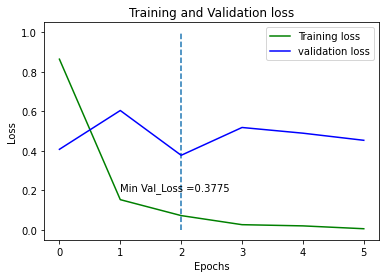

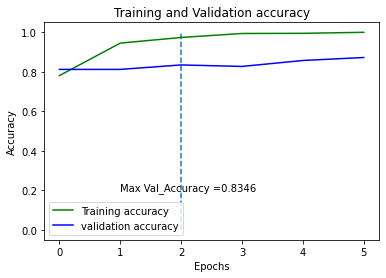

Metrics saving complete.


In [44]:
# VGG16 Architecture::
if TRANSFER_LEARNING_AUG:
    
    TL_VGG16_Aug_image_model_name="Config_TL_VGG16_Aug_Image"   
    
    model_tl_vgg16_aug = TL_model(TL_VGG16_Aug_image_model_name,"VGG16")
    
    history_tl_vgg16_aug = compile_fit_model(model_tl_vgg16_aug,TL_VGG16_Aug_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_vgg16_aug,TL_VGG16_Aug_image_model_name)

    write_metrics(history_tl_vgg16_aug,TL_VGG16_Aug_image_model_name)
    

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

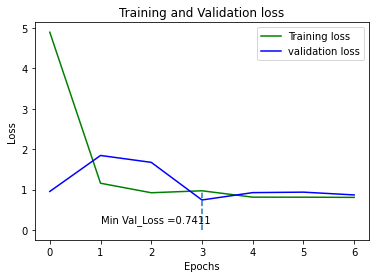

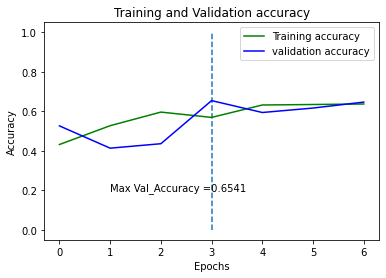

Metrics saving complete.


In [45]:
# ResNet50 Architecture::
if TRANSFER_LEARNING_AUG:
    
    TL_ResNet50_Aug_image_model_name="Config_TL_ResNet50_Aug_Image"   
    
    model_tl_ResNet50_aug = TL_model(TL_ResNet50_Aug_image_model_name,"ResNet50")
    
    history_tl_ResNet50_aug = compile_fit_model(model_tl_ResNet50_aug,TL_ResNet50_Aug_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_ResNet50_aug,TL_ResNet50_Aug_image_model_name)
    
    write_metrics(history_tl_ResNet50_aug,TL_ResNet50_Aug_image_model_name)    


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

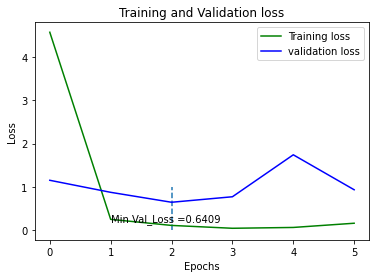

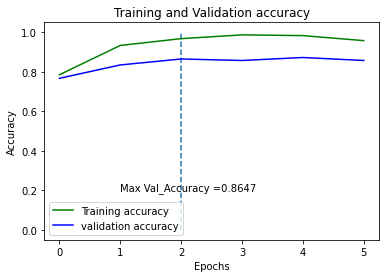

Metrics saving complete.


In [46]:
# InceptionV3 Architecture::
if TRANSFER_LEARNING_AUG:
    
    TL_InceptionV3_Aug_image_model_name="Config_TL_InceptionV3_Aug_Image"   
    
    model_tl_InceptionV3_aug = TL_model(TL_InceptionV3_Aug_image_model_name,"InceptionV3")
    
    history_tl_InceptionV3_aug = compile_fit_model(model_tl_InceptionV3_aug,TL_InceptionV3_Aug_image_model_name,X_train, y_train,X_validate,y_validate,25)
    
    model_performance(history_tl_InceptionV3_aug,TL_InceptionV3_Aug_image_model_name)
    
    write_metrics(history_tl_InceptionV3_aug,TL_InceptionV3_Aug_image_model_name)    

In [47]:
if TRANSFER_LEARNING_AUG:
    import gc
    %xdel X_train
    %xdel model_tl_vgg16_aug
    %xdel model_tl_ResNet50_aug
    %xdel model_tl_InceptionV3_aug
    
    collected = gc.collect() 
    print("Garbage collector: collected %d objects." % (collected) )

Garbage collector: collected 10716 objects.
